In [8]:
import numpy as np 
import matplotlib.pyplot as plt

In [9]:
n_visible =784
n_hidden = 50
hidden_bias = np.random.randn(n_hidden)
visible_bias = np.random.randn(n_visible)
v0_state = np.zeros(n_visible, np.float32)
W = np.zeros((n_visible, n_hidden), np.float32)



In [10]:
#temp
a = np.array([[1, 2, 3], [5, 6, 7], [8, 9, 10]])
b = np.array([[1], [2], [3]])
c = np.dot(a, b)
c = a @ b
print(type(c))
print(c)


<class 'numpy.ndarray'>
[[14]
 [38]
 [56]]


In [11]:
def sigmoid(X):
    return 1 / (1 + np.exp(X))
def relu(X):
    return np.maximum(X, 0)

In [12]:
#computing the hidden nodes probability vector
h0_prob = sigmoid(([v0_state] @ W) + hidden_bias); 
print(h0_prob.shape)
print(type(h0_prob))
print("first 15 hidden probs: ", h0_prob[0][:15])

#return only the generated hidden states
def hidden_layer(v0_state, W, hb):
    h0_prob = sigmoid(([v0_state] @ W) + hb)
    h0_state = relu(np.sign(h0_prob - np.random.uniform(low=0.0, high=1.0, size=h0_prob.shape)))
    return h0_state[0]
h0_state  = hidden_layer(v0_state, W, hidden_bias)

print(f'first 15 hidden states:{h0_state[:15]}')
print(h0_state.shape)
    

(1, 50)
<class 'numpy.ndarray'>
first 15 hidden probs:  [0.87183703 0.40400225 0.47043211 0.29400841 0.92656674 0.69534431
 0.74878808 0.46840073 0.42368491 0.47860524 0.57960838 0.29280076
 0.47794455 0.46903236 0.07354554]
first 15 hidden states:[1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0.]
(50,)


In [13]:
#reconstruction from hidden nodes
def reconstructed_output(h0_state, W, vb): 
    v1_prob = sigmoid(([h0_state] @ W.T) + vb)
    v1_state = relu(np.sign(v1_prob - np.random.uniform(low= 0.0, high = 1.0, size=v1_prob.shape)))
    return v1_state[0]

print(W.T.shape)
v1_state = reconstructed_output(h0_state, W, visible_bias)
print("hidden state shape:" ,h0_state.shape)
print("v1 state shape:", v1_state.shape)
print(v1_state[:5])

(50, 784)
hidden state shape: (50,)
v1 state shape: (784,)
[1. 0. 0. 1. 1.]


<h2>Goal</h2>
 <b>Maximize the liklihood of our data being drawn from that distribution</b>
<h2>Error Calculation</h2>
In each epoch, the "error" is computed as a sum of the squared difference between step 1 and step n, i.e the difference between the original data and it's reconstruction
<br>The Mean Square Error(MSE)


In [14]:
def error(v0_state, v1_state):
    squared_diff = np.square(v0_state - v1_state)
    mse = np.mean(squared_diff)
    return mse
err = error(v0_state, v1_state)
print(err)

0.5114795918367347


<h2>Training the model</h2>
In order to train the RBM, the goal is to maximize the product of probabilities assigned to all rows <b>v</b> in the training set <b>V</b>(a matrix) 
$$\arg \max_W \prod_{\mathbf{v}\in\mathbf{V}_T} p(\mathbf{v})$$

this is equivalent to maximizing the expectation of the log probability,
$$\arg\max_W\left[ \mathbb{E} \left(\prod_{\mathbf v\in \mathbf V}\text{log} \left(p(\mathbf v)\right) \right) \right]$$


so the approach is to update the weights $W_{ij}$ to increase <b>p(v)</b> for all <b>v</b>, so we need to calculate the derivative
$$\frac{\partial \log p(\mathbf v)}{\partial W_{ij}}$$

This cannot be implemented using the usual gradient descent algorithm, so another approach is used that includes: 
<ol>
    <li>Gibbs Sampling</li>
    <li>Contrastive Divergence</li>
</ol>

....to be added later


<h3>Class Implementaion</h3>

In [1]:
class RBM:
    def __init__(self, n_visible,n_hidden): 
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        

SyntaxError: incomplete input (3216169320.py, line 1)

In [72]:
#ignore this, generated by gpt
class BoltzmannMachine:
    def __init__(self, n_visible, n_hidden): 
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.weights = np.random.randn(n_visible, n_hidden)
        self.visible_bias = np.random.randn(n_visible)
        self.hidden_bias = np.random.randn(n_hidden)
        return 
    def sigmoid(self, x):
        return np.exp(np.minimum(x, 0)) / (1 + np.exp(-np.abs(x)))

    def gibbs_sampling(self, visible_data, num_iterations = 1000): 
        samples = np.zeros((num_iterations, self.n_visible))
        visible_state = visible_data
        for t in range(num_iterations): 
            hidden_probs = self.sigmoid(np.dot(visible_state, self.weights) + self.hidden_bias)
            hidden_state = np.random.binomial(1, hidden_probs)
            visible_probs = self.sigmoid(np.dot(hidden_state, self.weights.T)  + self.visible_bias)
            visible_state = np.random.binomial(1, visible_probs) 
            samples[t] = visible_state
        return samples 
    def train(self, data, learning_rate=0.1, num_epochs=1000):
        for epoch in range(num_epochs):
            data_batch = data[np.random.randint(data.shape[0])]
            data_batch = data_batch.reshape(1,-1)
            positive_hidden_probs = self.sigmoid(np.dot(data_batch, self.weights) + self.hidden_bias)
            # print(self.weights.shape)
            # print(positive_hidden_probs.shape)
            # print(data_batch.shape)
            positive_hidden_state = np.random.binomial(1, positive_hidden_probs)
            positive_associations = np.dot(data_batch.T, positive_hidden_probs)

            negative_visible_probs = self.sigmoid(np.dot(positive_hidden_state, self.weights.T) + self.visible_bias)
            negative_visible_state = np.random.binomial(1, negative_visible_probs)
            negative_hidden_probs = self.sigmoid(np.dot(negative_visible_state, self.weights) + self.hidden_bias)
            negative_associations = np.dot(negative_visible_state.T, negative_hidden_probs)

            self.weights += learning_rate * (positive_associations - negative_associations)
            self.visible_bias += learning_rate * np.mean(data_batch - negative_visible_state, axis=0)
            self.hidden_bias += learning_rate * np.mean(positive_hidden_state - negative_hidden_probs, axis=0)

        
        

<h2>Normal Implementation</h2>

In [15]:
import tensorflow as tf
from keras.datasets import mnist

In [16]:
(train_X, train_y), (test_X, test_y)= mnist.load_data()

In [17]:
def create_batches(data, label, batch_size):
    num_samples = len(data)
    num_batches = num_samples // batch_size
    if num_samples % batch_size != 0:
        num_batches += 1
    batches = []
    for i in range(num_batches):
        start_index = i * batch_size
        end_index = min((i+1) * batch_size, num_samples)#last batch ko lagi if num_samples % batch_size != 0 
        batch_data = data[start_index:end_index]
        batch_label = label[start_index:end_index]
        batches.append((batch_data, batch_label))
    return batches

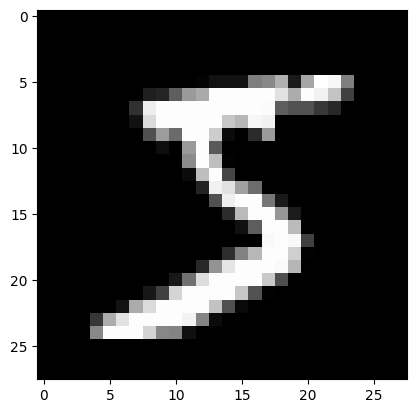

In [18]:
a = train_X[0]
plt.imshow(a, cmap = "gray")

In [19]:
print(train_X.shape)

(60000, 28, 28)


In [61]:
train_X_flattened = train_X.reshape(train_X.shape[0], -1)
print(train_X_flattened.shape)
y = train_X_flattened[:200]
print(y.shape)

(60000, 784)
(200, 784)


In [20]:
#main training 
alpha = 0.01
epochs = 10
batchsize = 200
weights = []
errors = []
batch_number = 0
K = 1

#creating batches 
train_ds = create_batches(train_X, train_y, batchsize)

In [27]:
print(train_ds[0][0].shape)
print(train_ds[0][1].shape)

(200, 28, 28)
(200,)
